In [1]:
from IPython.display import display,Image,clear_output
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
import random
import urllib.request
import h5py

from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter,defaultdict


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import save_model

In [3]:
from keras import backend as K
K.backend()

'tensorflow'

In [4]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

In [5]:
location = r'E:\code\Car_damage_evaluation\car-damage-dataset\data3a'
top_model_weights_path = os.path.join(location, 'top_model_weights.h5')  # Update the file extension
fine_tuned_model_path = os.path.join(location, 'ft_model.keras')

# Image dimensions and data directories
img_width, img_height = 256, 256
train_data_dir = os.path.join(location, 'training')
val_data_dir = os.path.join(location, 'validation')

# Calculate samples in training and validation datasets
train_samples = [len(os.listdir(os.path.join(train_data_dir, i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir, i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

# Model settings
nb_epoch = 50
batch_size = 16


In [6]:
train_samples

[278, 315, 386]

In [7]:
K.image_data_format()

'channels_last'

In [8]:
if K.image_data_format() == 'channels_first':
    input_shape = (3,img_height,img_widthdth)
else:
    input_shape = (img_height,img_width,3)

In [9]:

input_shape

(256, 256, 3)

In [10]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

In [11]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [13]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [15]:
import traceback

def save_bottleneck_features(location):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    try:
        train_bottleneck_path = os.path.join(location, 'bottleneck_features_train.npy')
        if os.path.exists(train_bottleneck_path):
            print('Already exists:', train_bottleneck_path)
        else:
            train_generator = datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode=None,
                shuffle=False
            )
            bottleneck_features_train = base_model.predict(train_generator, steps=nb_train_samples // batch_size, verbose=1)
            print('Saving:', train_bottleneck_path)
            np.save(train_bottleneck_path, bottleneck_features_train)
        
        val_bottleneck_path = os.path.join(location, 'bottleneck_features_val.npy')
        if os.path.exists(val_bottleneck_path):
            print('Already exists:', val_bottleneck_path)
        else:
            val_generator = datagen.flow_from_directory(
                val_data_dir,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode=None,
                shuffle=False
            )
            bottleneck_features_val = base_model.predict(val_generator, steps=nb_val_samples // batch_size, verbose=1)
            print('Saving:', val_bottleneck_path)
            np.save(val_bottleneck_path, bottleneck_features_val)

    except Exception as e:
        print("An error occurred while saving bottleneck features:", e)
        traceback.print_exc()


In [32]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

def train_categorical_model(location, epochs, batch_size):
    # Load training and validation data
    train_data = np.load(location + '/bottleneck_features_train.npy')
    validation_data = np.load(location + '/bottleneck_features_val.npy')

    # Ensure that the number of labels matches the number of samples
    num_train_samples = train_data.shape[0]
    num_class_0 = num_train_samples // 3
    num_class_1 = num_train_samples // 3
    num_class_2 = num_train_samples - (num_class_0 + num_class_1)

    train_labels = np.array([0] * num_class_0 + [1] * num_class_1 + [2] * num_class_2)
    np.random.shuffle(train_labels)

    num_val_samples = validation_data.shape[0]
    num_val_class_0 = num_val_samples // 3
    num_val_class_1 = num_val_samples // 3
    num_val_class_2 = num_val_samples - (num_val_class_0 + num_val_class_1)

    validation_labels = np.array([0] * num_val_class_0 + [1] * num_val_class_1 + [2] * num_val_class_2)
    np.random.shuffle(validation_labels)

    train_labels = to_categorical(train_labels, num_classes=3)
    validation_labels = to_categorical(validation_labels, num_classes=3)

    # Model building
    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))     # 8, 8, 512
    #model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=3,activation='softmax'))

    # Compile the model with a higher learning rate
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks: EarlyStopping and ModelCheckpoint
    checkpoint = ModelCheckpoint(location + '/top_model_weights.weights.h5', 
                                 monitor='val_accuracy', verbose=1, 
                                 save_best_only=True, save_weights_only=True)
    

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[checkpoint])

    # Save the training history
    with open(location + '/top_history_no_reg.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history


In [17]:
val_data = np.load(open(location+'/bottleneck_features_val.npy','rb'))
val_data.shape

(171, 8, 8, 512)

In [18]:
import json
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

def finetune_categorical_model():
    input_tensor = Input(shape=(256, 256, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    print("Model loaded.")

    # Define top model
    top_model = Sequential([
        Flatten(input_shape=base_model.output_shape[1:]),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Adjust number of classes if needed
    ])

    # Load top model weights if they exist
    try:
        top_model.load_weights(top_model_weights_path)
        print("Top model weights loaded successfully.")
    except Exception as e:
        print("Error loading weights:", e)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    # Freeze all layers in base model except the last few layers for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-4:]:  # Fine-tune the last few layers
        layer.trainable = True

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=1e-4, momentum=0.9),  # Adjusted learning rate
        metrics=['accuracy']
    )

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    # Training and validation generators
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Ensure validation data is consistent
    )

    # Model checkpoint callback
    checkpoint = ModelCheckpoint(
        fine_tuned_model_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='auto'
    )

    # Calculate steps for training and validation
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)

    # Train the model
    fit = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[checkpoint],
        verbose=1
    )

    # Save training history
    with open(f"{location}/ft_history.txt", 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

def evaluate_categorical_model(model, directory, labels, Force=False):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    if os.path.exists(location + '/pred_labels.npy') and not Force:
        print('Already exists', location + '/pred_labels.npy')
        pred_labels = np.load(open(location + '/pred_labels.npy', 'rb'))
    else:
        # Generate test data
        test_generator = test_datagen.flow_from_directory(
            directory=directory,
            target_size=(img_height, img_width),
            batch_size=8,
            class_mode='categorical',     # 'categorical' for multiclass
            shuffle=False
        )
        
        # Calculate steps
        steps = int(np.ceil(len(labels) / 8))  # Use ceiling to ensure all batches are processed
        
        # Get predictions
        predictions = model.predict(test_generator, steps=steps, verbose=1)
        
        # For multiclass classification
        pred_labels = np.argmax(predictions, axis=1)
    
        # Ensure matching lengths before saving
        if len(pred_labels) == len(labels):
            print('Saving', location + '/pred_labels.npy')
            np.save(open(location + '/pred_labels.npy', 'wb'), pred_labels)
        else:
            print(f"Warning: Prediction length ({len(pred_labels)}) does not match labels length ({len(labels)})")
            return None  # Exit if lengths do not match
    
    # Print classification report and confusion matrix
    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
    return cm



In [20]:
import matplotlib.pyplot as plt

def plot_metrics(hist, stop=50):  # stop -> number of data points in plot
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot training & validation accuracy values
    ax0.plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    # Plot training & validation loss values
    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Display best model results
    print("Best Model:")
    print_best_model_results(hist)


In [21]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [22]:
import numpy as np

def print_best_model_results(model_hist):
    # Use the correct key 'val_accuracy' instead of 'val_acc'
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('Epoch:', best_epoch + 1, 
          ', val_accuracy:', model_hist['val_accuracy'][best_epoch], 
          ', val_loss:', model_hist['val_loss'][best_epoch])

In [24]:
# do not rerun!!
save_bottleneck_features(location)

Already exists: E:\code\Car_damage_evaluation\car-damage-dataset\data3a\bottleneck_features_train.npy
Already exists: E:\code\Car_damage_evaluation\car-damage-dataset\data3a\bottleneck_features_val.npy


In [25]:
sns.set_style('whitegrid')

In [33]:
d3a_model1,d3a_history1 = train_categorical_model(location,nb_epoch, batch_size)    

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3089 - loss: 1.3245
Epoch 1: val_accuracy improved from -inf to 0.40936, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data3a/top_model_weights.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3089 - loss: 1.3238 - val_accuracy: 0.4094 - val_loss: 7.0043
Epoch 2/50
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3261 - loss: 1.1214
Epoch 2: val_accuracy did not improve from 0.40936
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3265 - loss: 1.1211 - val_accuracy: 0.4035 - val_loss: 7.0571
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3845 - loss: 1.0906
Epoch 3: val_accuracy did not improve from 0.40936
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3843 - loss: 1.0907 - val_accuracy: 0.4094 - val_loss: 7.0884
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3872 - loss: 1.0821
Epoch 4: val_accuracy did not improve from 0.40936
86/86

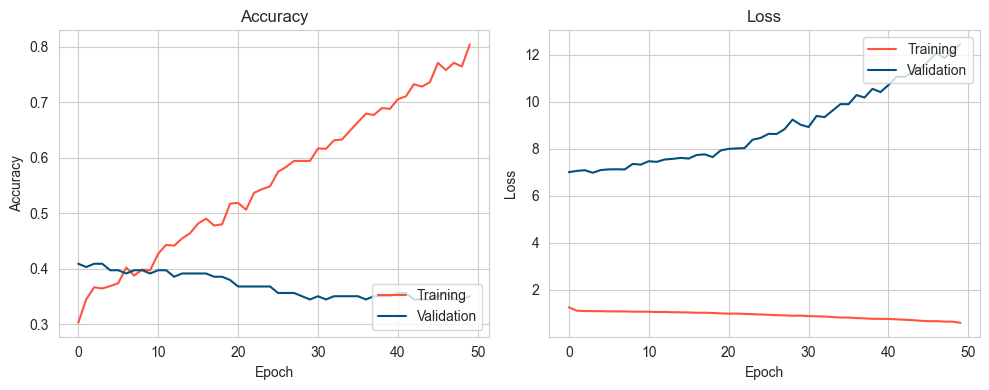

Best Model:
Epoch: 1 , val_accuracy: 0.4093567132949829 , val_loss: 7.004270553588867


In [35]:
plot_metrics(d3a_history1)

In [37]:
ft_model,ft_history = finetune_categorical_model()

Model loaded.
Top model weights loaded successfully.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50


e:\code\myenv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_45']. Received: the structure of inputs=*
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4990 - loss: 1.2669
Epoch 1: val_accuracy improved from -inf to 0.63743, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data3a\ft_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5003 - loss: 1.2622 - val_accuracy: 0.6374 - val_loss: 0.7658
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


C:\Users\sombi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
e:\code\myenv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6835 - loss: 0.7323
Epoch 3: val_accuracy improved from 0.63743 to 0.66667, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data3a\ft_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6832 - loss: 0.7327 - val_accuracy: 0.6667 - val_loss: 0.7232
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6920 - loss: 0.6782
Epoch 5: val_accuracy did not improve from 0.66667
62/62 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6921 - loss: 0.6786 - val_accuracy: 0.6608 - val_loss: 0.7156
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7283 - loss: 0.6788
Epoch 7: val_accuracy improved from 0.66667 to 0.67836, saving model to E:\code\Car_damage_evaluation\car-damage-dataset\data3a\ft_model.keras
62/62

ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

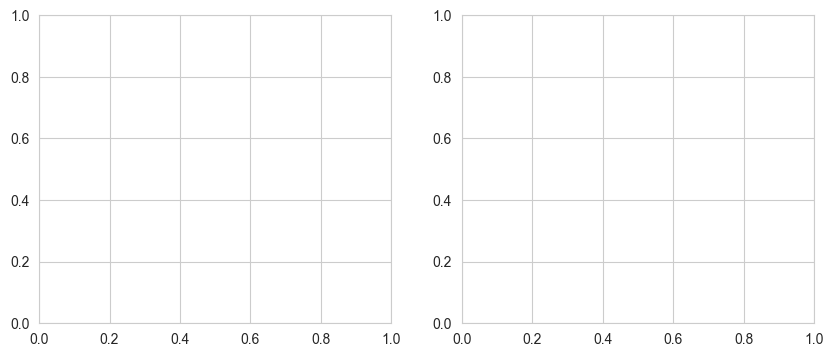

In [43]:
# Winner
plot_metrics(ft_history,stop=10)  

In [45]:
from keras.models import load_model
ft_model = load_model(fine_tuned_model_path)

In [46]:
with open(location+'/top_history.txt') as f:    
    top_history = json.load(f)

KeyError: 'accuracy'

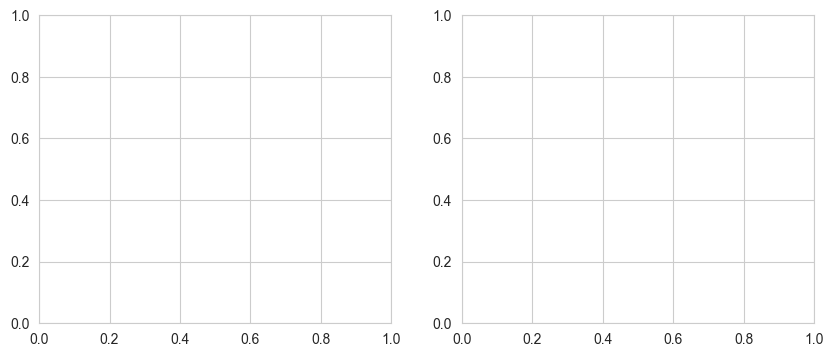

In [47]:

plot_metrics(top_history)

In [48]:
with open(location+'/ft_history.txt') as f:    
    ft_history = json.load(f)

In [49]:
val_labels = np.array([0] * val_samples[0] + 
                      [1] * val_samples[1] +
                      [2] * val_samples[2])
val_labels = to_categorical(val_labels)

In [50]:
cm = evaluate_categorical_model(ft_model, val_data_dir, np.argmax(val_labels,axis=1),Force=True)

Found 171 images belonging to 3 classes.


e:\code\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 745ms/step
Saving E:\code\Car_damage_evaluation\car-damage-dataset\data3a/pred_labels.npy

              precision    recall  f1-score   support

           0       0.75      0.56      0.64        48
           1       0.47      0.49      0.48        55
           2       0.71      0.81      0.76        68

    accuracy                           0.64       171
   macro avg       0.64      0.62      0.63       171
weighted avg       0.64      0.64      0.64       171




In [51]:
def plot_acc_metrics(hist1, hist2, stop1=50,stop2=10):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop1), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop1), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop2), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop2), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout()

KeyError: 'acc'

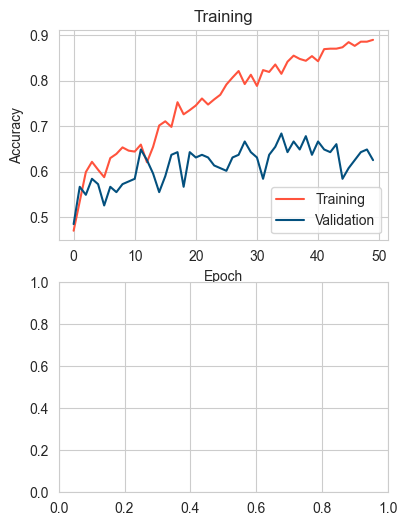

In [52]:
plot_acc_metrics(top_history, ft_history)

In [53]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

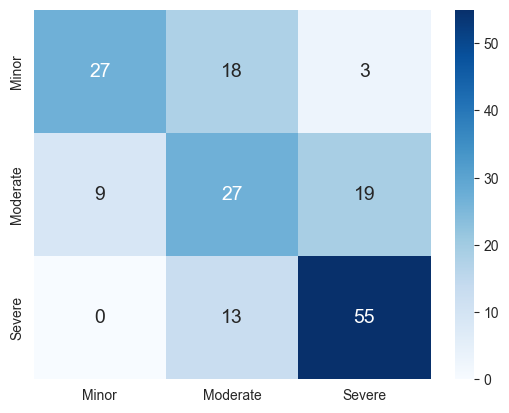

In [54]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [55]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [56]:
def severity_estimator(image_path, model):
    print("Determining severity of damage...")
    urllib.request.urlretrieve(image_path, 'save_4th_gate.jpg') # or other way to upload image
    img = load_img('save_4th_gate.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
#     print(pred_label)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Severity assessment complete.")

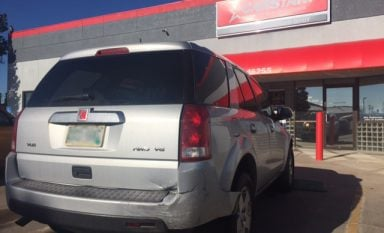

In [57]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [58]:
severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Determining severity of damage...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Assessment: Minor damage to vehicle
Severity assessment complete.


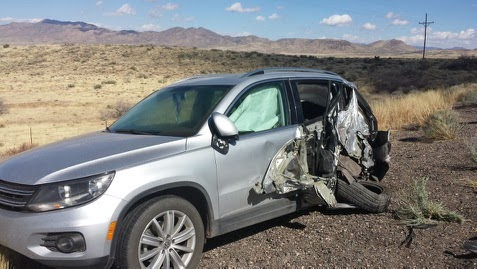

In [59]:
Image('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg')

In [60]:
severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_model)

Determining severity of damage...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Assessment: Severe damage to vehicle
Severity assessment complete.


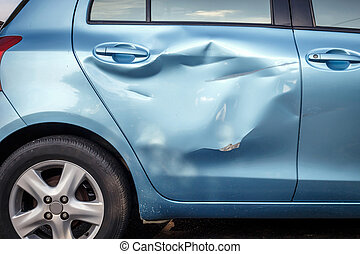

In [61]:
Image('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg')

In [62]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_model)

Determining severity of damage...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Assessment: Minor damage to vehicle
Severity assessment complete.
